# [Catch](https://gist.github.com/EderSantana/c7222daa328f0e885093)

In [1]:
from IPython.display import HTML
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd

Using TensorFlow backend.


In [20]:
class Catch(object): # 1 game is just 1 fruit dropped from top to bottom
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.basketSize = 0 #2*basketSize+1
        self.reset()
    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]    #array( [[0, n, m]] )
        #fruit_row, fruit_col, basket location
    def _update_state(self, action):
        """Input action and states., output new states and reward """
        state = self.state
        if action == 0:   action = -1 # left
        elif action == 1: action =  0 # stay
        else:             action =  1 # right
        f0, f1, basket = state[0]
        new_basket = min(max(self.basketSize, basket + action), self.grid_size-self.basketSize)
        f0 += 1                       # fruit dropped by one pixel
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]
        assert len(out.shape) == 2
        self.state = out
    def _draw_state(self):
        im_size = (self.grid_size, self.grid_size)
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1           # draw fruit
        canvas[-1, state[2]-self.basketSize:state[2] + self.basketSize+1] = 1  # draw basket
        return canvas
    def _get_reward(self):   # inc/dec score only if fruit has dropped to bottom
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            return 1 if abs(fruit_col - basket) <= self.basketSize else -1
        else:
            return 0
#         return 1 if abs(fruit_col - basket) <= 1 and fruit_row == self.grid_size-1 else -abs(fruit_col - basket)
    def _is_over(self):    # game over if fruit dropped to bottom
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False
    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))
    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

In [21]:
class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount
    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?],
        # state is the full canvas; action=0,1,2 [move_left, stay, move_right]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]
    def get_batch(self, model, batch_size=10):   #in: state; out: Q(s,a) for all a
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])): # random pick from memory with repetitions
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]
            inputs[i:i+1] = state_t
            targets[i] = model.predict(state_t)[0]    # no target values for actions not taken.
            Q_sa = np.max(model.predict(state_tp1)[0])# max among 3 rewards (corr 3 actions) 
            if game_over:
                targets[i, action_t] = reward_t
            else: # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

In [22]:
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
epoch = 50000
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10

model = Sequential()
model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(num_actions))
model.compile(sgd(lr=.2), "mse")

env = Catch(grid_size)
exp_replay = ExperienceReplay(max_memory=max_memory)

win_cnt = 0
for e in range(epoch):
    loss = 0.
    env.reset()
    game_over = False
    input_t = env.observe()  #current canvas

    while not game_over:
        input_tm1 = input_t
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, num_actions, size=1)
        else:
            q = model.predict(input_tm1)
            action = np.argmax(q[0])
        input_t, reward, game_over = env.act(action)
        if reward == 1: win_cnt += 1
            
        exp_replay.remember([input_tm1, action, reward, input_t], game_over)
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
        loss += model.train_on_batch(inputs, targets)
    if (e+1)%(epoch/10)==0:
        print("Epoch {:06d} | Loss {:.4f} | Win rate {:.3f}".format(e+1, loss, win_cnt/(epoch/10.)))
        win_cnt=0

# model.save_weights("model.h5", overwrite=True)
# with open("model.json", "w") as outfile: json.dump(model.to_json(), outfile)

Epoch 005000 | Loss 0.0078 | Win rate 0.194
Epoch 010000 | Loss 0.0003 | Win rate 0.244
Epoch 015000 | Loss 0.0018 | Win rate 0.366
Epoch 020000 | Loss 0.0013 | Win rate 0.575
Epoch 025000 | Loss 0.0001 | Win rate 0.672
Epoch 030000 | Loss 0.0003 | Win rate 0.776
Epoch 035000 | Loss 0.0010 | Win rate 0.775
Epoch 040000 | Loss 0.0001 | Win rate 0.838
Epoch 045000 | Loss 0.0011 | Win rate 0.860
Epoch 050000 | Loss 0.0000 | Win rate 0.883


### Evaluation

In [24]:
win_cnt = 0.
epoch = 1000
for e in range(epoch):
    loss = 0.
    env.reset()
    game_over = False
    input_t = env.observe()  #current canvas

    while not game_over:
        input_tm1 = input_t
        q = model.predict(input_tm1)
        action = np.argmax(q[0])
        input_t, reward, game_over = env.act(action)
        if reward == 1: win_cnt += 1
            
        exp_replay.remember([input_tm1, action, reward, input_t], game_over)
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
        loss += model.train_on_batch(inputs, targets)
print("Epoch {:06d} | Loss {:.4f} | Win rate {:.3f}".format(e+1, loss, win_cnt/epoch))

Epoch 001000 | Loss 0.0000 | Win rate 1.000


### Visualization

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
frames = []

for e in range(100):
    loss = 0.
    env.reset()
    game_over = False
    input_t = env.observe()
    frames.append(input_t.reshape((grid_size,)*2))
    while not game_over:
        input_tm1 = input_t
        q = model.predict(input_tm1)
        action = np.argmax(q[0])
        input_t, reward, game_over = env.act(action)
        frames.append(input_t.reshape((grid_size,)*2))
# plt.imshow(frames[9],interpolation='none', cmap='gray')

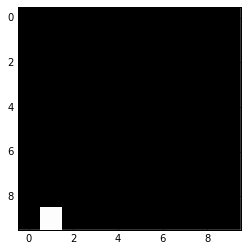

In [34]:
#animation
fig, ax = plt.subplots()
im  = ax.imshow(np.random.random((grid_size,)*2),interpolation='none', cmap='gray')
def init():
#     im.set_array(np.random.random((grid_size,grid_size)))
    return (im,)
def animate(i):
    im.set_array(frames[i])
    return (im,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(frames), interval=50, blit=True)
HTML(anim.to_html5_video())

In [ ]:
#save to files
for i in range(len(frames)):
    plt.imshow(frames[i],interpolation='none', cmap='gray')
    plt.savefig("%03d.png" % i)

# Flappy